# Importación modulos y datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
#data = pd.read_csv("merge_20220812.csv", low_memory=False) 

In [2]:
data = pd.read_csv("../data/conchillas_orig.csv", low_memory=False) 

# Exploración y limpieza de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       423 non-null    int64  
 1   Individuo  423 non-null    int64  
 2   AE         423 non-null    float64
 3   LE         423 non-null    float64
 4   AT         423 non-null    float64
 5   LT         423 non-null    float64
 6   AA         423 non-null    float64
 7   LA         423 non-null    float64
 8   NV         423 non-null    float64
 9   Morfotipo  423 non-null    object 
 10  Labio      422 non-null    float64
 11  cox1-lsu   105 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 39.8+ KB


In [4]:
data = data.dropna(subset=['Labio'])

In [ ]:
data.iloc[:,2:].describe()

In [ ]:
print(pd.value_counts(data["Morfotipo"], sort = True, normalize=True))

In [ ]:
print(pd.value_counts(data["Labio"], sort = True, normalize=True))

In [ ]:
data['cox1-lsu'].value_counts()

### Creación columnas nuevas

In [5]:
#Creamos un Filtro con NV > 4.75 y presencia de labio (divide adulto de joven???)
data["Filtro_NV"] = np.where(np.logical_or(data["NV"] > 4.75, data["Labio"] == 1),True,False)

In [ ]:
print(pd.value_counts(data["Filtro_NV"], sort = True, normalize=True))

In [6]:
data["Ratio_AE_LE"] = data["AE"]/data["LE"]
data["Ratio_AA_LA"] = data["AA"]/data["LA"]
data["Ratio_AT_LT"] = data["AT"]/data["LT"]

#aux copy: 'Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA'

In [ ]:
data.head()

### Relación entre variables

In [ ]:
#variables originales del dataset
sns.heatmap(data.iloc[8:,8:].corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

In [ ]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],hue='Morfotipo',plot_kws={'alpha': 0.5},aspect=1.5);

In [ ]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],hue='Filtro_NV',plot_kws={'alpha': 0.5},aspect=1.5);

In [ ]:
sns.pairplot(data=data,x_vars=['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'],\
         y_vars=['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'],\
             hue='Morfotipo',plot_kws={'alpha': 0.5},aspect=1.5, markers=['o','s','D'],palette='CMRmap', height=1.5);

### Distribución de las observaciones

In [ ]:
def distribution_plotter(data, label, bins="auto"):    
    plt.figure(figsize = (10,5))
    sns.set_style("white")    
    dist = sns.histplot(data, bins=bins, stat = "count", kde = False, 
                        line_kws = {'linewidth':5}, 
                        binwidth = 500)    
    dist.set_title('Distribucion ', fontsize = 16)
    plt.xticks(rotation=45, ha='right')

In [ ]:
distribution_plotter(data["Morfotipo"],data["Morfotipo"].unique())

In [9]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

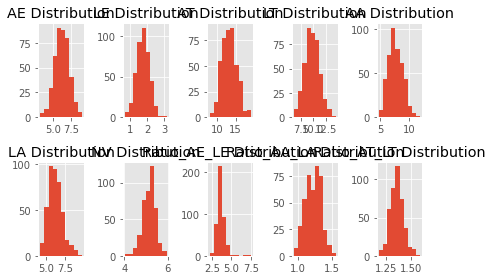

In [10]:
draw_histograms(data, data[["AE","LE","AT","LT","AA","LA","NV","Ratio_AE_LE","Ratio_AA_LA","Ratio_AT_LT"]], 2, 5)

# Modelos de clustering

## Importación modulos y dataset

In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## Prueba Kmeans

### Con las variables originales

In [15]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score,classification_report,confusion_matrix
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm


In [13]:
x = data[['AE','LE','AT','LT','AA','LA','NV']]
y_true = data["Morfotipo"]

scaler = StandardScaler()
x_scaled=scaler.fit_transform(x);

In [ ]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

In [ ]:
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    score=silhouette_score(x_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

In [ ]:
for n_clusters in range(2,10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_scaled[:, 0], x_scaled[:, 1], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Variables")
    ax2.set_ylabel("Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

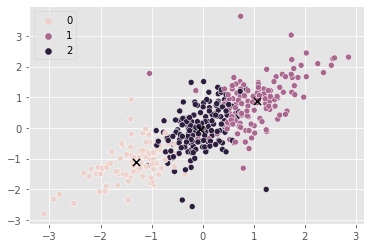

In [16]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_scaled[:,0],y=x_scaled[:,1],hue=labels,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

In [ ]:
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

### Con todas las variables (menos Labio y Filtro_NV)

In [17]:
x_R = data[['AE','LE','AT','LT','AA','LA','NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
#x_R = data[['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
y_true = data["Morfotipo"]

scaler = StandardScaler()
x_R_scaled=scaler.fit_transform(x_R);

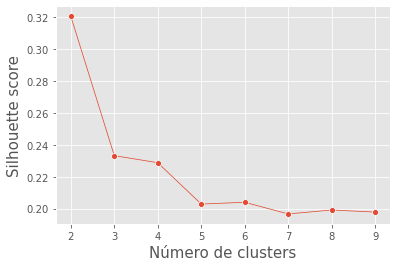

In [18]:
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_R_scaled)
    score=silhouette_score(x_R_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

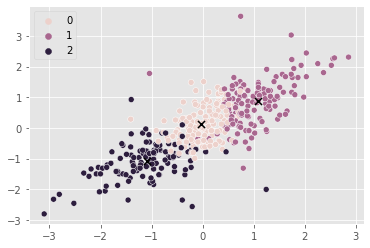

In [19]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_R_scaled)

labels_R = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids_R = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_R_scaled[:,0],y=x_R_scaled[:,1],hue=labels_R,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids_R[:,0],centroids_R[:,1],marker='x',s=50,color='k');

Text(0.5, 1.0, 'Kmeans_R')

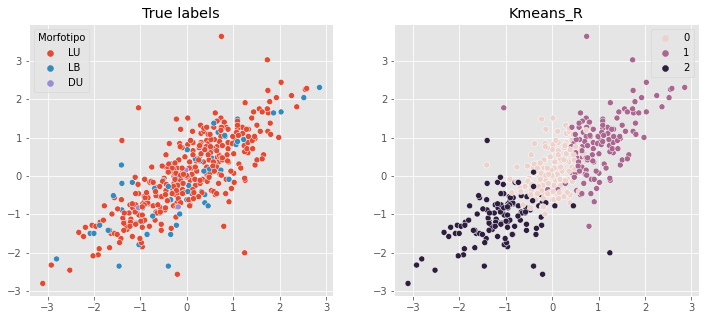

In [20]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_R,ax=ax[1])
ax[1].set_title('Kmeans_R')

## DBSCAN

In [21]:
from scipy.spatial.distance import pdist,squareform

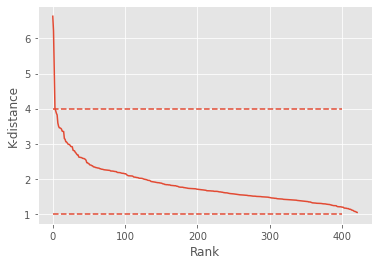

In [23]:
minPts=20;
k=minPts-1;

D=squareform(pdist(x_R_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([1,4],0,400,linestyles='dashed');

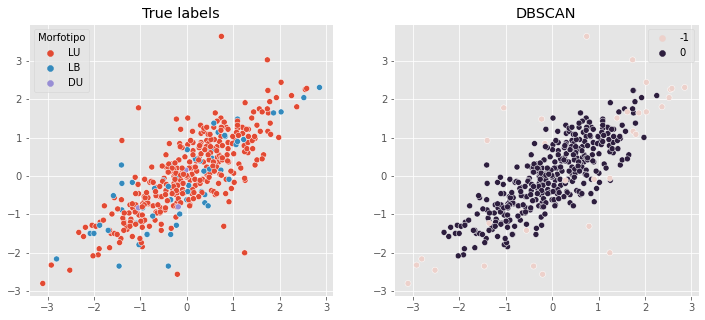

In [24]:
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x_R_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');

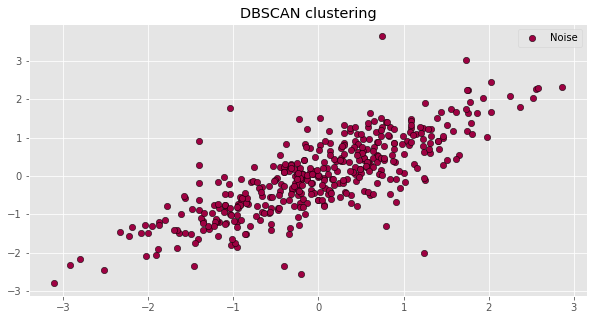

In [25]:
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x_R_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

# Modelos reducción dimensionalidad

## Prueba PCA

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [27]:
std_sclr = StandardScaler()

X = data[['AE','LE','AT','LT','AA','LA','NV','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]

data_std = pd.DataFrame(std_sclr.fit_transform(X))

In [28]:
model = PCA()

In [29]:
model_pca = model.fit(data_std)

### Pesos (loadings)

In [37]:
#Creamos un DataFrame con los loadings.
pca_loadings = pd.DataFrame(model_pca.components_.T, index=X.columns).iloc[:,:]
pca_loadings.rename(columns = {0 : 'CP1', 1 : 'CP2', 2 : 'CP3', 3 : 'CP4',4 : 'CP5', 5 : 'CP6', 6 : 'CP7', 7 : 'CP8',8 : 'CP9', 9 : 'CP10', 10 : 'CP11'}, inplace = True)
pca_loadings

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11
AE,-0.385116,0.055902,-0.027710,0.010733,-0.051609,0.214698,-0.600212,0.074599,-0.657684,-0.013416,0.019253
LE,-0.336930,-0.339281,-0.030243,0.126700,0.265425,0.106860,-0.370823,0.449537,0.574864,-0.033348,-0.036809
AT,-0.380131,0.203264,0.003221,0.146945,0.058779,-0.081438,-0.057197,-0.520859,0.182775,0.058033,-0.686407
LT,-0.391155,0.033953,-0.143020,0.092439,-0.140689,-0.111372,-0.065733,-0.493530,0.237906,0.025676,0.692457
AA,-0.374110,0.157013,0.069103,0.200648,-0.146445,-0.284116,0.326992,0.285690,-0.100572,-0.699563,-0.011837
LA,-0.316767,0.287667,-0.391300,0.061563,0.106474,-0.209948,0.319207,0.372572,-0.110097,0.592837,0.017473
NV,-0.343272,-0.110869,0.067141,-0.279579,-0.025562,0.752574,0.467472,-0.038411,0.001021,-0.012413,-0.004326
Filtro_NV,-0.219384,-0.019200,0.232848,-0.843318,0.161536,-0.395460,-0.057655,0.006050,0.014930,-0.005712,0.000823
Ratio_AE_LE,0.087950,0.641113,0.001584,-0.206401,-0.518551,0.201589,-0.243791,0.212133,0.352309,-0.013148,-0.019312
Ratio_AA_LA,-0.158443,-0.178083,0.743073,0.226261,-0.394545,-0.124086,0.067181,0.102535,-0.016804,0.391518,0.013094


In [38]:
pca_loadings.T.dot(pca_loadings)

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11
CP1,1.000000e+00,-6.586365e-17,-5.919192e-17,-2.960821e-17,3.062158e-17,-1.723598e-17,8.013697e-17,-1.420625e-17,1.438508e-16,4.191110e-17,-4.774050e-17
CP2,-6.586365e-17,1.000000e+00,1.045269e-16,1.148485e-16,-5.113140e-17,2.876717e-16,-3.318129e-16,-8.660895e-17,2.750136e-16,-3.067218e-17,-1.192596e-17
CP3,-5.919192e-17,1.045269e-16,1.000000e+00,8.643896e-17,-6.364293e-17,1.324804e-17,1.200298e-16,1.285891e-16,-1.646241e-16,1.507420e-16,-8.886953e-17
CP4,-2.960821e-17,1.148485e-16,8.643896e-17,1.000000e+00,3.989785e-16,1.254915e-16,1.400163e-16,-9.881534e-17,1.085143e-17,5.090021e-17,-9.431972e-19
CP5,3.062158e-17,-5.113140e-17,-6.364293e-17,3.989785e-16,1.000000e+00,1.460493e-16,2.354133e-16,-1.009002e-16,-4.734768e-17,3.508499e-17,1.967305e-16
CP6,-1.723598e-17,2.876717e-16,1.324804e-17,1.254915e-16,1.460493e-16,1.000000e+00,-5.054965e-16,3.380032e-17,3.370056e-17,2.099885e-16,-7.193718e-18
CP7,8.013697e-17,-3.318129e-16,1.200298e-16,1.400163e-16,2.354133e-16,-5.054965e-16,1.000000e+00,-3.845168e-17,3.466502e-16,1.989919e-17,7.174390e-17
CP8,-1.420625e-17,-8.660895e-17,1.285891e-16,-9.881534e-17,-1.009002e-16,3.380032e-17,-3.845168e-17,1.000000e+00,2.019860e-16,-3.196874e-16,2.633799e-16
CP9,1.438508e-16,2.750136e-16,-1.646241e-16,1.085143e-17,-4.734768e-17,3.370056e-17,3.466502e-16,2.019860e-16,1.000000e+00,-5.052629e-17,-5.844749e-18
CP10,4.191110e-17,-3.067218e-17,1.507420e-16,5.090021e-17,3.508499e-17,2.099885e-16,1.989919e-17,-3.196874e-16,-5.052629e-17,1.000000e+00,2.399231e-17


In [39]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

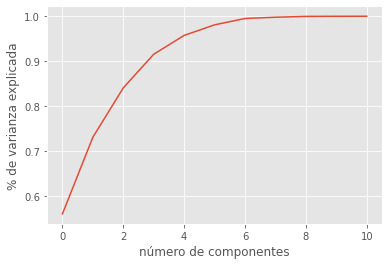

In [40]:
plot_explained_variance(components_count = 11, X = data_std)

### Proyección

In [41]:
#nuevo dataset con cada participación de feature
nuevo_data_pca = pd.DataFrame(model_pca.fit_transform(data_std), index =X.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11'])

In [42]:
nuevo_data_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-1.372979,-1.162151,-0.768364,0.136827,1.227442,-0.275423,0.545264,0.148201,0.275761,-0.004351,-0.014667
1,2.073829,0.735717,-0.282821,-0.962097,0.656942,0.205726,-0.170415,0.079382,-0.119273,-0.053238,0.005623
2,-0.421082,-0.286731,0.937238,0.202414,-0.038497,-0.453776,0.148785,-0.113929,0.048584,0.017466,-0.001891
3,-0.009121,-2.877301,0.811225,-0.596335,-0.464495,0.983630,-0.415430,0.201357,0.010626,0.055228,-0.029021
4,0.921651,0.789905,-1.046621,-0.901876,0.831386,0.296982,0.082989,0.051411,-0.123165,0.006057,-0.005650
5,1.202337,0.776630,-0.617111,-1.003679,1.085713,0.756915,-0.205864,0.037155,-0.163331,-0.045082,-0.002611
7,-1.327534,-1.206629,0.613296,0.194568,-0.509443,-0.191779,-0.399814,0.149005,-0.041750,0.001426,0.011387
8,0.456664,-0.983069,-0.999123,-0.983265,0.472706,0.791354,-0.568534,-0.241750,-0.013611,-0.043158,-0.017945
9,0.243127,-0.477970,1.063612,-0.219219,-0.078693,0.139125,0.170963,0.073555,-0.077869,0.009854,-0.002799
10,-0.367488,-1.330352,0.661664,-0.208907,-0.546389,0.124536,-0.201709,0.072501,-0.055487,0.022659,0.001296


In [43]:
nuevo_data_pca.shape

(422, 11)

In [48]:
model_pca.explained_variance_ratio_

array([5.60929753e-01, 1.70271169e-01, 1.09738734e-01, 7.46562708e-02,
       4.18663674e-02, 2.34361270e-02, 1.41098284e-02, 2.78835857e-03,
       1.84849593e-03, 2.66487383e-04, 8.84085618e-05])

### Bastón quebrado

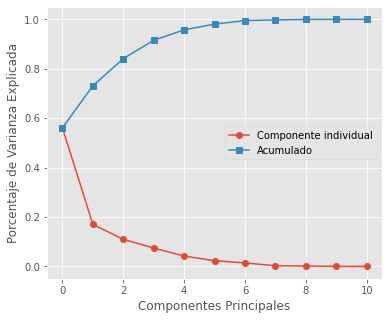

In [30]:
plt.figure(figsize=(6,5))

plt.plot(model_pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

## Prueba TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(random_state=42)

proj_tsne = tsne.fit_transform(data_std)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne[:, 0]
coord_y = proj_tsne[:, 1]
ax.plot(coord_x, coord_y, '.k')    

# Modelos clasificación

## CART con oversampling

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
newX = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
newy = data['Morfotipo']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(newX,newy,stratify = data['Morfotipo'],random_state=0)

In [ ]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

### OverSampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

In [ ]:
X_train_os2,y_train_os2=oversampler.fit_resample(X_train_os,y_train_os);

print('Composición del training set:')
print(y_train_os2.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

## CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 7, random_state=42)
clf_dt = clf_dt.fit(X_train_os2,y_train_os2)

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["LU","DU", "LB"], 
          feature_names=X_train_os2.columns); 

In [ ]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["LU","DU","LB"])